# Hello, KAN!

### Kolmogorov-Arnold representation theorem

Kolmogorov-Arnold representation theorem states that if $f$ is a multivariate continuous function
on a bounded domain, then it can be written as a finite composition of continuous functions of a
single variable and the binary operation of addition. More specifically, for a smooth $f : [0,1]^n \to \mathbb{R}$,


$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

where $\phi_{q,p}:[0,1]\to\mathbb{R}$ and $\Phi_q:\mathbb{R}\to\mathbb{R}$. In a sense, they showed that the only true multivariate function is addition, since every other function can be written using univariate functions and sum. However, this 2-Layer width-$(2n+1)$ Kolmogorov-Arnold representation may not be smooth due to its limited expressive power. We augment its expressive power by generalizing it to arbitrary depths and widths.

### Kolmogorov-Arnold Network (KAN)

The Kolmogorov-Arnold representation can be written in matrix form

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

where 

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

We notice that both ${\bf \Phi}_{\rm in}$ and ${\bf \Phi}_{\rm out}$ are special cases of the following function matrix ${\bf \Phi}$ (with $n_{\rm in}$ inputs, and $n_{\rm out}$ outputs), we call a Kolmogorov-Arnold layer:

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

${\bf \Phi}_{\rm in}$ corresponds to $n_{\rm in}=n, n_{\rm out}=2n+1$, and ${\bf \Phi}_{\rm out}$ corresponds to $n_{\rm in}=2n+1, n_{\rm out}=1$.

After defining the layer, we can construct a Kolmogorov-Arnold network simply by stacking layers! Let's say we have $L$ layers, with the $l^{\rm th}$ layer ${\bf \Phi}_l$ have shape $(n_{l+1}, n_{l})$. Then the whole network is

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

In constrast, a Multi-Layer Perceptron is interleaved by linear layers ${\bf W}_l$ and nonlinearities $\sigma$:

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

A KAN can be easily visualized. (1) A KAN is simply stack of KAN layers. (2) Each KAN layer can be visualized as a fully-connected layer, with a 1D function placed on each edge. Let's see an example below.

### Get started with KANs

Initialize KAN

In [1]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

Create dataset

In [2]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

Plot KAN at initialization

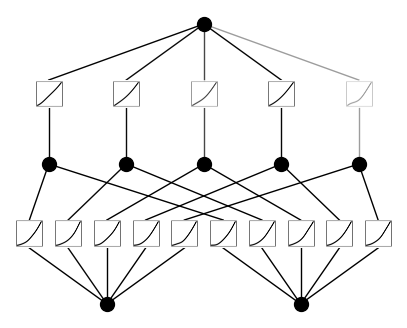

In [3]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

In [4]:
# params save stem
dir_stem = 'params'
os.makedirs(dir_stem, exist_ok=True)

In [5]:
# Save the initial parameters
theta0 = model.state_dict().copy()
torch.save(theta0, os.path.join(dir_stem, 'theta0.pth'))
print('Saved initial parameters to', os.path.join(dir_stem, 'theta0.pth'))

Saved initial parameters to params/theta0.pth


Train KAN with sparsity regularization

In [6]:
# train the model
model.train_model(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 1.23e-01 | test loss: 1.26e-01 | reg: 1.86e+01 : 100%|██| 20/20 [00:12<00:00,  1.66it/s]


Plot trained KAN

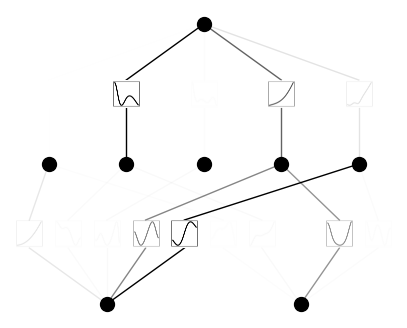

In [7]:
model.plot()

In [8]:
# Save the initial parameters
thetaN = model.state_dict().copy()
torch.save(thetaN, os.path.join(dir_stem, 'thetaN.pth'))
print('Saved final parameters to', os.path.join(dir_stem, 'thetaN.pth'))

Saved final parameters to params/thetaN.pth


Prune KAN and replot (keep the original shape)

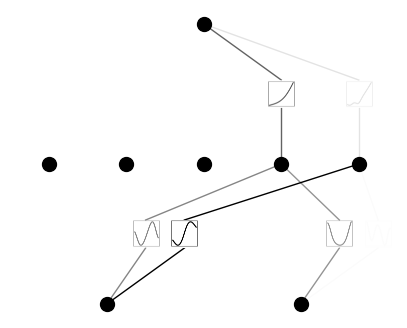

In [9]:
model.prune()
model.plot(mask=True)

Prune KAN and replot (get a smaller shape)

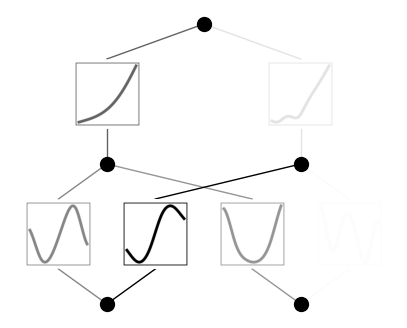

In [10]:
model = model.prune()
model(dataset['train_input'])
model.plot()

Continue training and replot

In [11]:
model.train_model(dataset, opt="LBFGS", steps=50);

train loss: 3.43e-03 | test loss: 3.45e-03 | reg: 5.30e+00 : 100%|██| 50/50 [00:18<00:00,  2.71it/s]


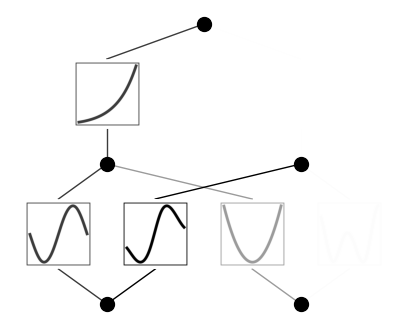

In [12]:
model.plot()

Automatically or manually set activation functions to be symbolic

In [13]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999678730964661
fixing (0,0,1) with sin, r2=0.9901396036148071
fixing (0,1,0) with x^2, r2=0.9999998807907104
fixing (0,1,1) with sin, r2=0.8737531304359436
fixing (1,0,0) with exp, r2=0.9999983310699463
fixing (1,1,0) with tanh, r2=0.9509005546569824


Continue training to almost machine precision

In [14]:
model.train_model(dataset, opt="LBFGS", steps=50);

train loss: 1.61e-06 | test loss: 1.55e-06 | reg: 5.18e+00 : 100%|██| 50/50 [00:06<00:00,  7.96it/s]


Obtain the symbolic formula

In [15]:
model.symbolic_formula()[0][0]

1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))

## Is KAN convex? 
No... :(

In [1]:
from kan import *

python(22258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [3]:
# Load initial and final parameters
dir_stem = 'params'
theta0 = torch.load(os.path.join(dir_stem, 'theta0.pth'))
thetaN = torch.load(os.path.join(dir_stem, 'thetaN.pth'))

# Linearly interpolate/extrapolate the parameters between theta0 and thetaN
alphas = np.linspace(-1.5, 2.0, 50)
thetas = [{name: (1-alpha)*theta0[name] + alpha*thetaN[name] for name in theta0} for alpha in alphas]

In [4]:
# Set up the model and define the loss
model = KAN(width=[2,5,1], grid=5, k=3)
criterion = nn.MSELoss()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


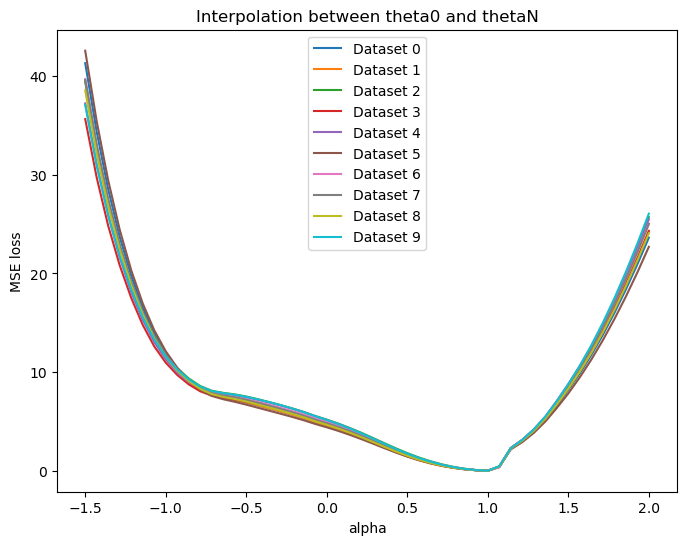

In [5]:
n_datasets = 10

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(n_datasets):
    # Create a new dataset
    dataset = create_dataset(f, n_var=2, seed=i)
    data = dataset['train_input']
    targets = dataset['train_label']

    # Compute the loss for each theta
    losses = []
    with torch.no_grad():  # No need to compute gradients for evaluation
        for theta in thetas:
            model.load_state_dict(theta)
            outputs = model(data)
            loss = criterion(outputs, targets)
            losses.append(loss.item())

    # Plot the loss as a function of alpha
    ax.plot(alphas, losses, label=f'Dataset {i}')

# add legend for each line
ax.legend()

plt.xlabel('alpha')
plt.ylabel('MSE loss')
plt.title('Interpolation between theta0 and thetaN')
plt.show()

### Spectrum Density

In [21]:
from kan import *
from pyhessian import hessian, get_esd_plot # Hessian computation
from matplotlib.backends.backend_pdf import PdfPages

In [22]:
# Set up the model and define the loss
model = KAN(width=[2,5,1], grid=5, k=3)
criterion = nn.MSELoss()

In [23]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

In [24]:
# Dataset
inputs = dataset['train_input']
targets = dataset['train_label']

In [25]:
pdf = PdfPages('figures/spec_density/kan.pdf')
for i, theta in enumerate(thetas):
    model.load_state_dict(theta)
    hessian_comp = hessian(model, criterion, data=(inputs,targets), cuda=False) 
    density_eigen, density_weight = hessian_comp.density()
    fig, ax = get_esd_plot(density_eigen, density_weight)
    ax.set_title(f'Spectrum of Hessian for alpha={alphas[i]:.2f}')
    pdf.savefig(fig, bbox_inches = 'tight')
    plt.close(fig)
pdf.close()        

/Users/ycchu/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1182.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/Users/ycchu/Documents/Research/KAN/code/pykan2/pykan/pyhessian/density_plot.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


### Eigvalue

In [26]:
hessian_comp = hessian(model, criterion, data=(inputs,targets), cuda=False)

In [27]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])

The top Hessian eigenvalue of this model is 869.7650


In [28]:
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=5)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: -8.3288 22.0197


In [14]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 226.4016


### MLP

In [1]:
from models.mlp import MLP
import torch

In [2]:
input_size = 100
output_size = 10
hidden_layers = [100, 100, 100]

model = MLP(input_size, output_size, hidden_layers)
loss_fn = torch.nn.CrossEntropyLoss()

In [3]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0936,  0.0628, -0.0233,  ..., -0.0598, -0.0404, -0.0751],
        [ 0.0338, -0.0975,  0.0664,  ..., -0.0700, -0.0986,  0.0468],
        [ 0.0811,  0.0082, -0.0113,  ..., -0.0749, -0.0914, -0.0058],
        ...,
        [ 0.0237, -0.0541,  0.0866,  ...,  0.0117,  0.0295, -0.0590],
        [ 0.0065,  0.0776, -0.0110,  ..., -0.0262, -0.0533, -0.0448],
        [-0.0249, -0.0036, -0.0586,  ..., -0.0013,  0.0629,  0.0091]],
       requires_grad=True)
Parameter containing:
tensor([-0.0803,  0.0992,  0.0803, -0.0689, -0.0450,  0.0717, -0.0260,  0.0193,
         0.0110, -0.0930, -0.0912, -0.0669, -0.0986, -0.0322,  0.0506,  0.0516,
        -0.0817,  0.0423,  0.0146, -0.0930,  0.0636, -0.0813, -0.0907, -0.0722,
        -0.0706, -0.0905,  0.0755, -0.0724,  0.0638, -0.0629, -0.0667,  0.0997,
         0.0139,  0.0053,  0.0425,  0.0967, -0.0445,  0.0229,  0.0392,  0.0205,
        -0.0984,  0.0043, -0.0455,  0.0770,  0.0409, -0.0600, -0.0106, -0.0664,
        -0.0629

In [4]:
from SFN import SFN
opt = SFN(model.parameters(), lr=0.01)

In [5]:
i = 0
for group in opt.param_groups:
    print(type(group['params']))
    for p in group['params']:
        if i == 0:
            print(p)
            print('------------------')
            print(p.grad)
            print('------------------')
        i += 1


<class 'list'>
Parameter containing:
tensor([[-0.0936,  0.0628, -0.0233,  ..., -0.0598, -0.0404, -0.0751],
        [ 0.0338, -0.0975,  0.0664,  ..., -0.0700, -0.0986,  0.0468],
        [ 0.0811,  0.0082, -0.0113,  ..., -0.0749, -0.0914, -0.0058],
        ...,
        [ 0.0237, -0.0541,  0.0866,  ...,  0.0117,  0.0295, -0.0590],
        [ 0.0065,  0.0776, -0.0110,  ..., -0.0262, -0.0533, -0.0448],
        [-0.0249, -0.0036, -0.0586,  ..., -0.0013,  0.0629,  0.0091]],
       requires_grad=True)
------------------
None
------------------


In [6]:
torch.cat([p.view(-1) for group in opt.param_groups for p in group['params']])

tensor([-0.0936,  0.0628, -0.0233,  ..., -0.0436,  0.0439, -0.0933],
       grad_fn=<CatBackward0>)

In [7]:
# Generate dummy data
batch_size = 32  # Example batch size
input_data = torch.randn(batch_size, input_size)
target_data = torch.randint(0, output_size, (batch_size,))

# Forward pass
output = model(input_data)
loss = loss_fn(output, target_data)

# Backward pass to compute gradients
grad_tuple = torch.autograd.grad(loss, model.parameters(), create_graph=True)

# Extract gradients
params = []
for group in opt.param_groups:
    for param in group['params']:
        params.append(param)

grad_params = torch.cat([gradient.view(-1) for gradient in grad_tuple if gradient is not None])

# Create a random vector v with the same size as the concatenated parameters
v = torch.randn(grad_params.size(0))

# Add an additional scalar value to v for tg computation
v_with_t = torch.cat([v, torch.tensor([1.0])])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [8]:
# Compute Hessian-vector product
Hv = opt._hvp(grad_params, params, v_with_t[:-1])
print("Hv shape: ", Hv.shape)

# Multiply the last element of v with grad_params
tg = v_with_t[-1] * grad_params
print("tg shape: ", tg.shape)

# Compute gTv
gTv = torch.dot(grad_params, v_with_t[:-1])
print("gTv shape: ", gTv.shape)

Hv_tg = Hv + tg
scalar = (gTv - opt.delta).view(1)

print("Hv_tg shape: ", Hv_tg.shape)
print("scalar shape: ", scalar.shape)

print("final shape: ", torch.cat([Hv_tg, scalar]).shape)

Hv shape:  torch.Size([31310])
tg shape:  torch.Size([31310])
gTv shape:  torch.Size([])
Hv_tg shape:  torch.Size([31310])
scalar shape:  torch.Size([1])
final shape:  torch.Size([31311])


In [9]:
# Call the _fvp method and print the output
fvp_output = opt._fvp(grad_params, list(model.parameters()), v_with_t)

Hv shape:  torch.Size([31310])
tg shape:  torch.Size([31310])
gTv shape:  torch.Size([])
Hv_tg shape:  torch.Size([31310])
scalar shape:  torch.Size([1])


In [10]:
print("v shape:", v.shape)
print("v_with_t shape:", v_with_t.shape)
print("grad_params shape:", grad_params.shape)
print("FVP Output Shape:", fvp_output.shape)

v shape: torch.Size([31310])
v_with_t shape: torch.Size([31311])
grad_params shape: torch.Size([31310])
FVP Output Shape: torch.Size([31311])
